In [ ]:
import numpy  as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
df = pd.read_csv('air-quality-india.csv')
df.head()

,Timestamp,Year,Month,Day,Hour,PM2.5
0,2017-11-07 12:00:00,2017,11,7,12,64.51
1,2017-11-07 13:00:00,2017,11,7,13,69.95
2,2017-11-07 14:00:00,2017,11,7,14,92.79
3,2017-11-07 15:00:00,2017,11,7,15,109.66
4,2017-11-07 16:00:00,2017,11,7,16,116.50


In [ ]:
df.isnull().sum()

Timestamp    0
Year         0
Month        0
Day          0
Hour         0
PM2.5        0
dtype: int64

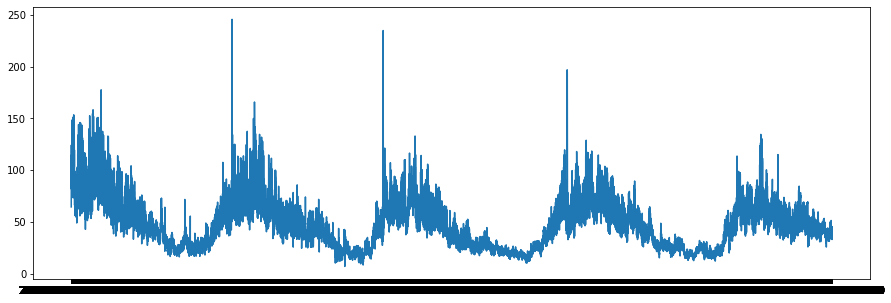

In [ ]:
dates = df['Timestamp'].values
pm = df['PM2.5'].values

plt.figure(figsize=(15,5))
plt.plot(dates, pm)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(pm, dates, test_size=0.2, shuffle=False)

In [ ]:
print(len(x_train))
print(len(x_valid))

28953
7239


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer) :
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [ ]:
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=1000)
valid_set = windowed_dataset(x_valid, 60, 100, 1000)

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
Mae = (df['PM2.5'].max() - df['PM2.5'].min()) * 10/100
Mae

23.861

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < Mae and logs.get('val_mae') < Mae):
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, validation_data=valid_set, callbacks=[callbacks])

Epoch 1/100


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


289/289 [==============================] - 15s 24ms/step - loss: 48.5828 - mae: 49.0828 - val_loss: 39.8855 - val_mae: 40.3855
Epoch 2/100
289/289 [==============================] - 6s 21ms/step - loss: 28.8976 - mae: 29.3935 - val_loss: 15.0819 - val_mae: 15.5746
Epoch 3/100
289/289 [==============================] - 6s 22ms/step - loss: 17.2974 - mae: 17.7879 - val_loss: 10.1270 - val_mae: 10.6123


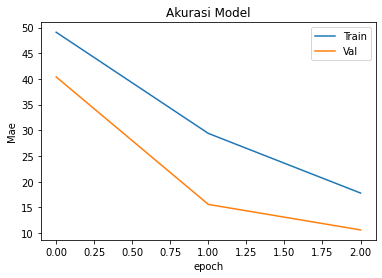

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Akurasi Model')
plt.ylabel('Mae')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

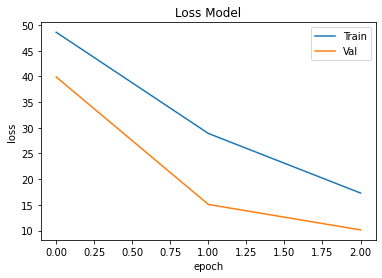

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()